<a href="https://colab.research.google.com/github/AnIsAsPe/Prediccion-produccion-electricidad/blob/main/Notebooks/Predicci%C3%B3n_producci%C3%B3n_electricidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [7]:
#import math

import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


# Funciones

In [8]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura de datos

In [78]:
file = 'https://raw.githubusercontent.com/AnIsAsPe/Prediccion-produccion-electricidad/main/Datos/IPG2211A2N.csv'
datos = pd.read_csv(file, index_col = [0], parse_dates=['DATE'])
datos = datos.loc['1990-01-01':]
datos.columns = ['Producción']  # NAICS 2211

datos

,Producción
DATE,
1990-01-01,83.2897
1990-02-01,76.1676
1990-03-01,72.2190
1990-04-01,66.3566
1990-05-01,64.9348
...,...
2021-04-01,87.2261
2021-05-01,88.7192
2021-06-01,103.5687


In [10]:
# revisamos si las fechas están ordenads
datos.index.is_monotonic

True

In [83]:
datos.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01'],
              dtype='datetime64[ns]', name='DATE', length=380, freq=None)

In [84]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01'],
              dtype='datetime64[ns]', name='DATE', length=380, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

# Exploración y Visualización de la Serie Temporal

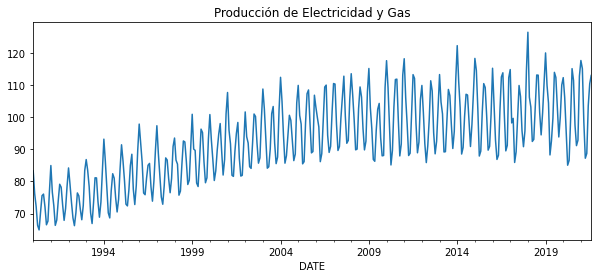

In [11]:
datos['Producción'].plot(figsize=(10,4), title='Producción de Electricidad y Gas')
plt.show()

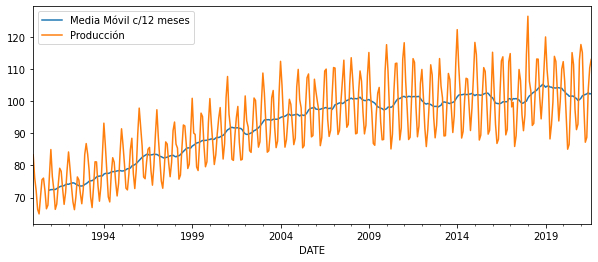

In [12]:
datos['Producción'].rolling(12).mean().plot(figsize=(10,4),label='Media Móvil c/12 meses')
datos['Producción'].plot()
plt.legend()
plt.show()

La fusncion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

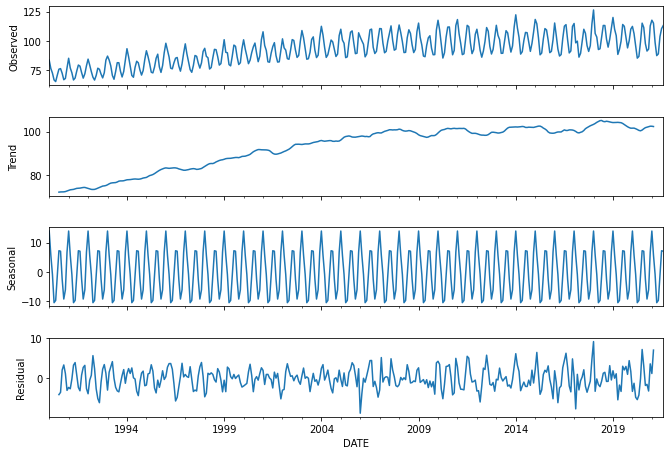

In [66]:
decomp = seasonal_decompose(datos['Producción']
                           # , freq=12, extrapolate_trend='freq'
                            )
fig =decomp.plot()
fig.set_size_inches(10,7)

# Convertir los datos a Estacionarios

Realizamos el test Dickey-Fuller en la cual, la hipótesis nula es que los datos no son estacionarios. (si p es muy pequeña, rechazaremos la hipotesis nula)
La hipotesis alternativa es que son estacionarios

In [87]:
pValue = adfuller(datos['Producción'])[1]
pValue

0.2135901950474307

In [88]:
p_value_adfuller(datos['Producción'])

P-value:  0.2135901950474307
No se rechaza la hipóteis nula, los datos no son estacionarios


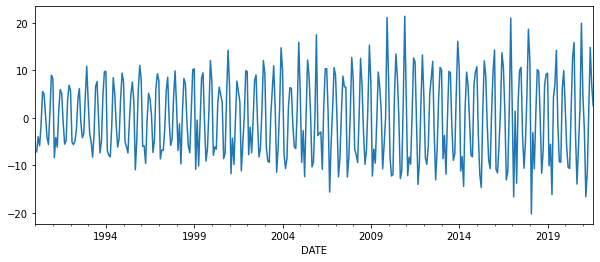

In [89]:
datos['1a diff']= datos['Producción'] - datos['Producción'].shift(1)  
datos['1a diff'].plot(figsize=(10,4))

In [90]:
p_value_adfuller(datos['1a diff'].dropna())

P-value:  7.880574511466663e-10
Se rechaza la hipótesis nula, los datos son estacionarios


# Visualización de la ACF y PACF

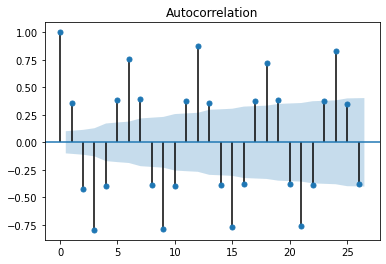

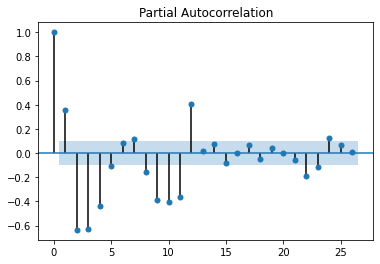

In [91]:
plot_acf(datos['1a diff'].dropna())
plot_pacf(datos['1a diff'].dropna())
plt.show()

# Construcción del modelo SARIMA



In [175]:
train = datos.loc[:'2020-08-01','Producción']
test = datos.loc['2020-08-01':,'Producción']

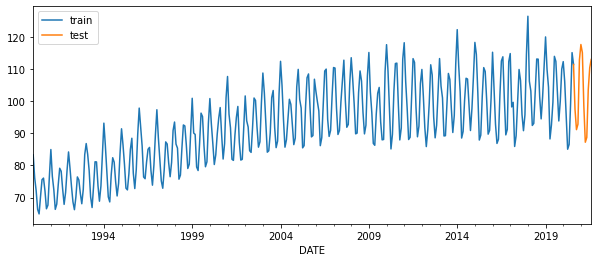

In [178]:
train.plot(label = 'train', figsize =(10,4))
test.plot(label = 'test', figsize =(10,4))
plt.legend()
plt.show()

In [179]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [180]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [182]:
aic_modelos = {}
for parametros in pdq:
  for parametros_s in seasonal_pdq:
      modelo = SARIMAX(datos.loc[:'2020-08-01','Producción'],
                       order = parametros,
                       seasonal_order = parametros_s,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
      results = modelo.fit(method_kwargs={"warn_convergence": False})
      aic_modelos[parametros, parametros_s] = results.aic
      print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))  

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC:4373.692554490017
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC:3800.2704411500818
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC:1956.8209348333087
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC:1883.1221124750073
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC:1945.0485584027206
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC:1890.1490596069325
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC:1892.1036883945162
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC:1885.083879214784
ARIMA(0, 0, 1) x (0, 0, 0, 12) - AIC:3890.3640890685574
ARIMA(0, 0, 1) x (0, 0, 1, 12) - AIC:3349.457738826824
ARIMA(0, 0, 1) x (0, 1, 0, 12) - AIC:1836.8168168664852
ARIMA(0, 0, 1) x (0, 1, 1, 12) - AIC:1749.112296108162
ARIMA(0, 0, 1) x (1, 0, 0, 12) - AIC:1838.1293055742967
ARIMA(0, 0, 1) x (1, 0, 1, 12) - AIC:1763.3157068653986
ARIMA(0, 0, 1) x (1, 1, 0, 12) - AIC:1769.1792349438747
ARIMA(0, 0, 1) x (1, 1, 1, 12) - AIC:1751.2344165404843
ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC:2582.3775573338944
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC:2242.6093414046

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0) x (1, 0, 1, 12) - AIC:1756.63606072009
ARIMA(0, 1, 0) x (1, 1, 0, 12) - AIC:1799.5029994929648
ARIMA(0, 1, 0) x (1, 1, 1, 12) - AIC:1716.749697043665
ARIMA(0, 1, 1) x (0, 0, 0, 12) - AIC:2480.094065994922
ARIMA(0, 1, 1) x (0, 0, 1, 12) - AIC:2202.206778377411
ARIMA(0, 1, 1) x (0, 1, 0, 12) - AIC:1846.8980000093788
ARIMA(0, 1, 1) x (0, 1, 1, 12) - AIC:1673.1239101029519
ARIMA(0, 1, 1) x (1, 0, 0, 12) - AIC:1851.0115060701992
ARIMA(0, 1, 1) x (1, 0, 1, 12) - AIC:1714.482698816054
ARIMA(0, 1, 1) x (1, 1, 0, 12) - AIC:1763.8665606165728
ARIMA(0, 1, 1) x (1, 1, 1, 12) - AIC:1675.121093679642
ARIMA(1, 0, 0) x (0, 0, 0, 12) - AIC:2590.7475114114704
ARIMA(1, 0, 0) x (0, 0, 1, 12) - AIC:2251.166782421803
ARIMA(1, 0, 0) x (0, 1, 0, 12) - AIC:1815.8224431517315
ARIMA(1, 0, 0) x (0, 1, 1, 12) - AIC:1687.6394552939041
ARIMA(1, 0, 0) x (1, 0, 0, 12) - AIC:1814.6906608745126
ARIMA(1, 0, 0) x (1, 0, 1, 12) - AIC:1716.8593232223361
ARIMA(1, 0, 0) x (1, 1, 0, 12) - AIC:1729.5784523417767


In [183]:
print('Modelo: ', min(aic_modelos, key =aic_modelos.get))
print('AIC: ',min(aic_modelos.values()))


Modelo:  ((1, 1, 1), (0, 1, 1, 12))
AIC:  1632.4013800947637


In [184]:
modelo = SARIMAX(datos['Producción'],
                       order = (1,1,1),
                       seasonal_order = (0,1,1,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4763      0.047     10.187      0.000       0.385       0.568
ma.L1         -0.9496      0.019    -50.149      0.000      -0.987      -0.913
ma.S.L12      -0.7840      0.034    -22.758      0.000      -0.852      -0.717
sigma2         7.0247      0.466     15.089      0.000       6.112       7.937


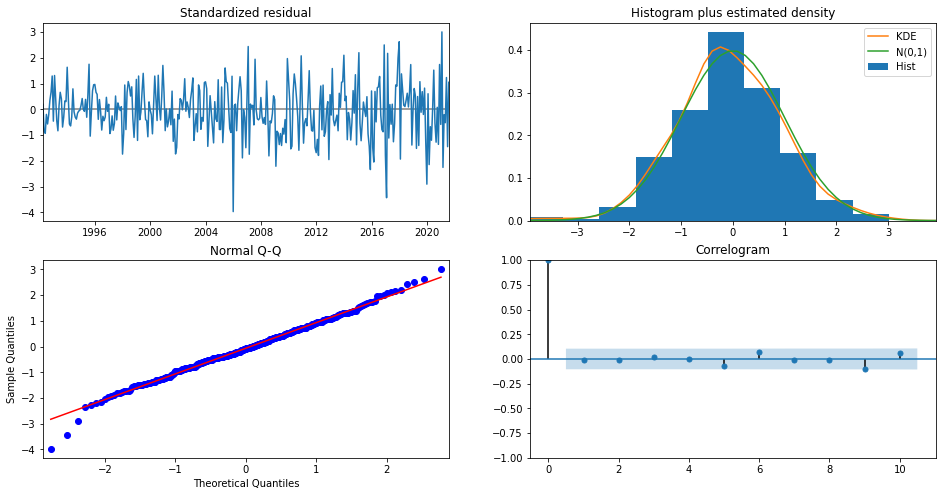

In [185]:
resultados.plot_diagnostics(figsize = (16,8))
plt.show()

# Validación

In [186]:
pred = resultados.get_prediction(start=pd.to_datetime('2020-08-01'),
                                 end=pd.to_datetime('2021-08-01'))
pred.predicted_mean

DATE
2020-08-01    112.816807
2020-09-01    100.862226
2020-10-01     90.934247
2020-11-01     96.434412
2020-12-01    108.158009
2021-01-01    119.165664
2021-02-01    107.092523
2021-03-01    104.467853
2021-04-01     87.779119
2021-05-01     90.092735
2021-06-01    100.288100
2021-07-01    114.249852
2021-08-01    110.174724
Freq: MS, dtype: float64

In [187]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower Producción,upper Producción
DATE,,
2020-08-01,107.622096,118.011517
2020-09-01,95.667516,106.056936
2020-10-01,85.739537,96.128957
2020-11-01,91.239702,101.629123
2020-12-01,102.963299,113.352719
2021-01-01,113.970954,124.360374
2021-02-01,101.897813,112.287233
2021-03-01,99.273143,109.662563
2021-04-01,82.584409,92.973829


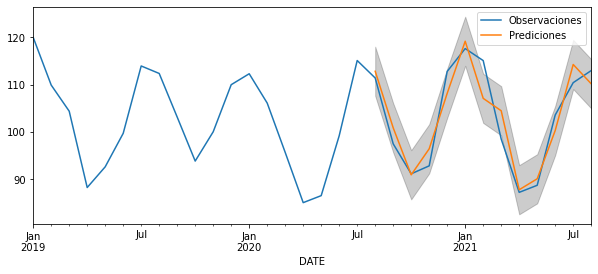

In [188]:
fig = datos.loc['2019-01-01':,'Producción'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

In [189]:
y_pred  = pred.predicted_mean
y_real = datos.loc['2020-08-01':,'Producción']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 14.25
La raiz del error cuadrático medio es 3.77
